<a href="https://colab.research.google.com/github/dinhngoc267/Machine-Learning-Course/blob/master/NLI_Contradictory%2C_My_Dear_Watson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Lib

In [1]:
pip install transformers

     |████████████████████████████████| 2.1MB 17.5MB/s 
     |████████████████████████████████| 901kB 51.7MB/s 
     |████████████████████████████████| 3.3MB 55.4MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns
os.environ["WANDB_API_KEY"] = "0" ## to silence warning
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
import keras.backend as K

from sklearn.model_selection import train_test_split

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


# Data Exploration

##Load training data

In [4]:
train = pd.read_csv("/content/drive/MyDrive/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("/content/drive/MyDrive/contradictory-my-dear-watson/test.csv")

In [ ]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


0 = entailment, 1 = neutral, 2 = contradiction

## Statist data by language

In [ ]:
train["language"].value_counts()

English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: language, dtype: int64

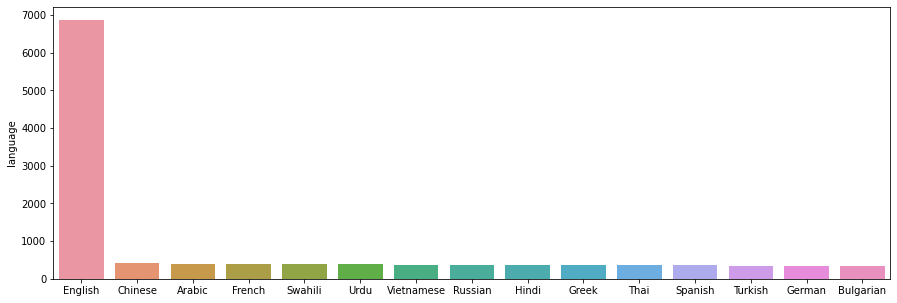

In [ ]:
plot = train["language"].value_counts()

plt.figure(figsize=(15,5))
sns.barplot(x=plot.index, y=plot)

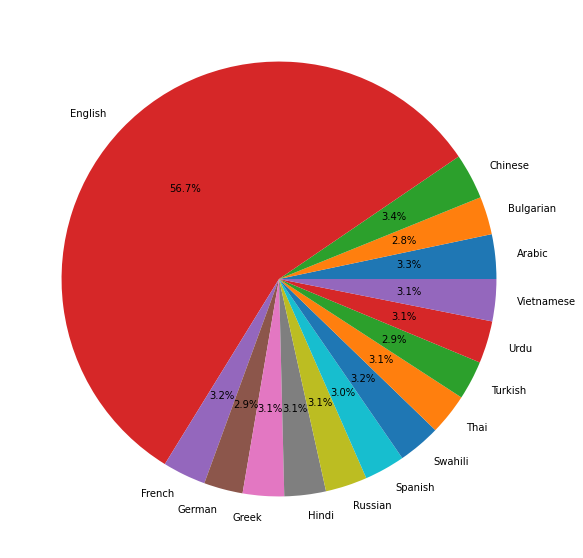

In [ ]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

## Check balance data

In [ ]:
train["label"].value_counts()

0    4176
2    4064
1    3880
Name: label, dtype: int64

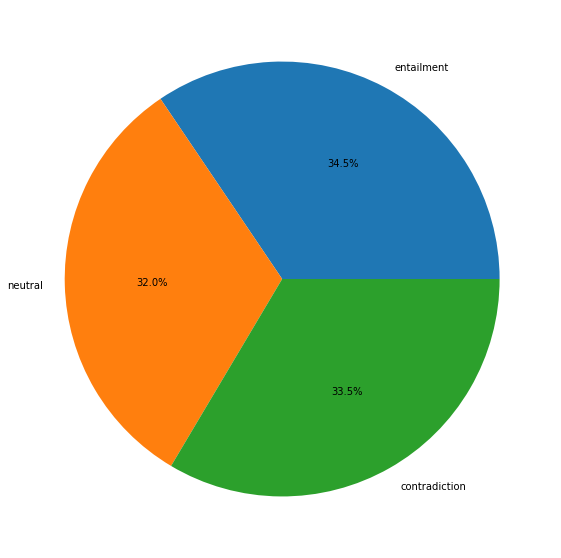

In [ ]:
labels, frequencies = np.unique(train.label.values, return_counts = True)
plt.figure(figsize = (10,10))
plt.pie(frequencies,labels =['entailment','neutral', 'contradiction'], autopct = '%1.1f%%')
plt.show()

## Data Preprocess

In [9]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
def bert_encode(hypotheses, premises, tokenizer, max_len = 512):
  all_tokens = []
  all_masks = []
  all_segments = []
  num_examples = len(hypotheses)

  for i in range(num_examples):
    sent1 = hypotheses[i]
    sent2 = premises[i]
    max_len_sent1 = max_len//2 -2
    max_len_sent2 = max_len_sent1+1

    sent1 = tokenizer.tokenize(sent1)
    sent2 = tokenizer.tokenize(sent2)
    sent1 = sent1[:max_len_sent1]
    sent2 = sent2[:max_len_sent2]

    input_sequence = ["[CLS]"] + sent1 + ["[SEP]"] + sent2 + ["[SEP]"] 
    pad_len = max_len - len(input_sequence)

    tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0]*pad_len
    pad_masks = [1]*len(input_sequence) + [0]*pad_len
    seqment_ids = [0]*(max_len_sent1+2) + [1]*(max_len_sent2+1)

    all_tokens.append(tokens)
    all_masks.append(pad_masks)
    all_segments.append(seqment_ids)

  return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [43]:
train_data = pd.DataFrame(train, columns=['hypothesis', 'premise'])
labels = pd.DataFrame(train, columns=['label'])

In [44]:
training_data, dev_data,training_label, dev_label = train_test_split(train_data, labels, test_size=0.2, random_state=13)

In [ ]:
train_input = bert_encode(training_data.hypothesis.values,training_data.premise.values, tokenizer,max_len=120)
dev_input = bert_encode(dev_data.hypothesis.values,dev_data.premise.values, tokenizer,max_len=120)

## Create model

In [ ]:
def build_model(max_len = 512):
  bert_encoder = TFBertModel.from_pretrained(model_name)
  input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
  input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
  input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
  embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
  output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
  model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
  return model

In [ ]:
model = build_model(max_len=120)
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 120)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 120)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_6 (TFBertModel)   TFBaseModelOutputWit 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/NLI Waston project/model.h5', monitor='val_accuracy', save_best_only=True, verbose=1,save_weights_only=True)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
train_history = model.fit(train_input, training_label, epochs = 5, verbose = 1, batch_size = 64, validation_data=(dev_input, dev_label), callbacks= [checkpoint, earlystopping])

Epoch 1/5
152/152 [==============================] - 255s 2s/step - loss: 1.1377 - accuracy: 0.3540 - val_loss: 1.0152 - val_accuracy: 0.5190

Epoch 00001: val_accuracy improved from -inf to 0.51898, saving model to /content/drive/MyDrive/NLI Waston project/model.h5
Epoch 2/5
152/152 [==============================] - 239s 2s/step - loss: 0.9650 - accuracy: 0.5364 - val_loss: 0.8736 - val_accuracy: 0.6101

Epoch 00002: val_accuracy improved from 0.51898 to 0.61015, saving model to /content/drive/MyDrive/NLI Waston project/model.h5
Epoch 3/5
152/152 [==============================] - 240s 2s/step - loss: 0.7676 - accuracy: 0.6620 - val_loss: 0.8502 - val_accuracy: 0.6291

Epoch 00003: val_accuracy improved from 0.61015 to 0.62913, saving model to /content/drive/MyDrive/NLI Waston project/model.h5
Epoch 4/5
152/152 [==============================] - 239s 2s/step - loss: 0.6217 - accuracy: 0.7447 - val_loss: 0.8962 - val_accuracy: 0.6320

Epoch 00004: val_accuracy improved from 0.62913 to

In [ ]:
y_pred = model.predict(dev_input)
y_pred2 = []
for row in y_pred:
  pred = np.argmax(row)
  y_pred2.append(pred)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['entailment','neutral', 'contradiction']
print(classification_report(dev_label, y_pred2, target_names=target_names))

               precision    recall  f1-score   support

   entailment       0.74      0.52      0.61       851
      neutral       0.55      0.70      0.61       773
contradiction       0.61      0.64      0.62       800

     accuracy                           0.62      2424
    macro avg       0.63      0.62      0.62      2424
 weighted avg       0.64      0.62      0.62      2424



## Sequence2Sequence

### Data preprocess

In [45]:
max_len = 120

input_tokens = []
target_tokens = []
total = []
for i, (input_text, target_text) in enumerate(zip(training_data.hypothesis.values, training_data.premise.values)):
  input_token = tokenizer.tokenize(input_text)
  input_token = tokenizer.convert_tokens_to_ids(input_token)
  target_token = tokenizer.tokenize(target_text)
  target_token = tokenizer.convert_tokens_to_ids(target_token)
  for token in input_token:
    total.append(token)
  for token in target_token:
    total.append(token)
  input_tokens.append(input_token)
  target_tokens.append(target_token)

max_encoder_seq_length = max([len(token) for token in input_tokens])
max_decoder_seq_length = max([len(token) for token in target_tokens])

for i,input_token in enumerate(input_tokens):
  input_tokens[i] = tf.keras.preprocessing.sequence.pad_sequences([input_token], maxlen=max_len, dtype='float32', padding='post', truncating='post')

for i,target_token in enumerate(target_tokens):
  target_tokens[i] = tf.keras.preprocessing.sequence.pad_sequences([target_token], maxlen=max_len, dtype='float32', padding='post', truncating='post')

input_tokens = np.array(input_tokens)
input_tokens = np.reshape(input_tokens, (input_tokens.shape[0],input_tokens.shape[2]) + (1,))
target_tokens = np.array(target_tokens)
target_tokens = np.reshape(target_tokens, (target_tokens.shape[0],target_tokens.shape[2]) + (1,))

seq2seq_training_data = []
for i in range(input_tokens.shape[0]):
  pair = [input_tokens[i],target_tokens[i]]
  seq2seq_training_data.append(pair)
seq2seq_training_data = np.array(seq2seq_training_data)

In [103]:
max_len = 120

dev_input_tokens = []
dev_target_tokens = []
total = []
for i, (input_text, target_text) in enumerate(zip(dev_data.hypothesis.values, dev_data.premise.values)):
  input_token = tokenizer.tokenize(input_text) 
  input_token = tokenizer.convert_tokens_to_ids(input_token)
  target_token = tokenizer.tokenize(target_text)
  target_token = tokenizer.convert_tokens_to_ids(target_token)

  dev_input_tokens.append(input_token)
  dev_target_tokens.append(target_token)

for i,input_token in enumerate(dev_input_tokens):
  dev_input_tokens[i] = tf.keras.preprocessing.sequence.pad_sequences([input_token], maxlen=max_len, dtype='float32', padding='post', truncating='post')

for i,target_token in enumerate(dev_target_tokens):
  dev_target_tokens[i] = tf.keras.preprocessing.sequence.pad_sequences([target_token], maxlen=max_len, dtype='float32', padding='post', truncating='post')

dev_input_tokens = np.array(dev_input_tokens)
dev_input_tokens = np.reshape(dev_input_tokens, (dev_input_tokens.shape[0],dev_input_tokens.shape[2]) + (1,))
dev_target_tokens = np.array(dev_target_tokens)
dev_target_tokens = np.reshape(dev_target_tokens, (dev_target_tokens.shape[0],dev_target_tokens.shape[2]) + (1,))

seq2seq_dev_data = []
for i in range(dev_input_tokens.shape[0]):
  pair = [dev_input_tokens[i],dev_target_tokens[i]]
  seq2seq_dev_data.append(pair)
seq2seq_dev_data = np.array(seq2seq_dev_data)
seq2seq_dev_data.shape

(2424, 2, 120, 1)

In [69]:
def create_base_network(input_shape): 
  model = Sequential()
  model.add(layers.Embedding(input_dim=111586, output_dim=100))
  model.add(layers.Dropout(0.4))
  model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=False)))
  model.add(layers.Dense(64, activation='relu'))
  return model
def cosine_distance(vects): 
  x,y=vects  
  t1_norm = tf.nn.l2_normalize(x, axis = 1)
  t2_norm = tf.nn.l2_normalize(y, axis = 1)

  cosine =  -tf.losses.cosine_similarity(t1_norm, t2_norm, axis = 1)
  return 1-cosine

# def euclidean_distance(vectors):
# 	# unpack the vectors into separate lists
# 	(featsA, featsB) = vectors
# 	# compute the sum of squared distances between the vectors
# 	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
# 		keepdims=True)
# 	# return the euclidean distance between the vectors
# 	return K.sqrt(K.maximum(sumSquared, K.epsilon()))


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def cos_dist_output_shape(shapes): 
  shape1, shape2 = shapes 
  return (shape1[0], 1)

def build_model(input_shape): 
  base_network = create_base_network(input_shape);
  input_a = layers.Input(shape=input_shape);
  input_b = layers.Input(shape=input_shape);

  processed_a = base_network(input_a);
  processed_b = base_network(input_b);

  #distance = layers.Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b]);
  #distance = layers.LambdaMerge([input1, input2], euclidean_distance)
  distance = layers.Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
  distance = distance*tf.ones((1,1), dtype=tf.dtypes.float32)
  #distance = tf.transpose(distance, perm=[1,0])
  #print(distance.shape)
  #distance = tf.keras.layers.Reshape((1,))([distance])
  clf_layer = layers.Dense(3, activation='softmax')(distance)
  model = keras.Model([input_a, input_b], clf_layer);
 
  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) 
  return model

In [104]:
model = build_model(seq2seq_training_data.shape[2:])

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_83 (InputLayer)           [(None, 120, 1)]     0                                            
__________________________________________________________________________________________________
input_84 (InputLayer)           [(None, 120, 1)]     0                                            
__________________________________________________________________________________________________
sequential_50 (Sequential)      (None, 128)          14086208    input_83[0][0]                   
                                                                 input_84[0][0]                   
__________________________________________________________________________________________________
lambda_36 (Lambda)              (None, 1)            0           sequential_50[0][0]        

In [18]:
seq2seq_training_labels = []
for l in training_label:
  tmp = np.zeros((3,))
  tmp[l] = 1
  seq2seq_training_labels.append(tmp)

seq2seq_training_labels = np.array(seq2seq_training_labels)

In [19]:
seq2seq_dev_labels = []
for l in dev_label:
  tmp = np.zeros((3,))
  tmp[l] = 1
  seq2seq_dev_labels.append(tmp)

seq2seq_dev_labels = np.array(seq2seq_dev_labels)

In [105]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/NLI Waston project/seq2seq_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
model.fit([seq2seq_training_data[:,0],seq2seq_training_data[:,1]] , seq2seq_training_labels, epochs=5, batch_size=64, validation_data=([seq2seq_dev_data[:,0], seq2seq_dev_data[:,1]], seq2seq_dev_labels), verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/5
152/152 [==============================] - 35s 178ms/step - loss: 1.0991 - accuracy: 0.3327 - val_loss: 1.0981 - val_accuracy: 0.3568

Epoch 00001: val_accuracy improved from -inf to 0.35685, saving model to /content/drive/MyDrive/NLI Waston project/seq2seq_model.h5
Epoch 2/5
152/152 [==============================] - 25s 165ms/step - loss: 1.0948 - accuracy: 0.3511 - val_loss: 1.0999 - val_accuracy: 0.3379

Epoch 00002: val_accuracy did not improve from 0.35685
Epoch 3/5
152/152 [==============================] - 25s 162ms/step - loss: 1.0536 - accuracy: 0.4038 - val_loss: 1.1078 - val_accuracy: 0.3564

Epoch 00003: val_accuracy did not improve from 0.35685
Epoch 4/5
152/152 [==============================] - 25s 163ms/step - loss: 0.9623 - accuracy: 0.4866 - val_loss: 1.1411 - val_accuracy: 0.3593

Epoch 00004: val_accuracy improved from 0.35685 to 0.35932, saving model to /content/drive/MyDrive/NLI Waston project/seq2seq_model.h5
Epoch 5/5
152/152 [========================

In [106]:
model.fit([seq2seq_training_data[:,0],seq2seq_training_data[:,1]] , seq2seq_training_labels, epochs=5, batch_size=64, validation_data=([seq2seq_dev_data[:,0], seq2seq_dev_data[:,1]], seq2seq_dev_labels), verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/5
152/152 [==============================] - 25s 164ms/step - loss: 0.8033 - accuracy: 0.5859 - val_loss: 1.2817 - val_accuracy: 0.3577

Epoch 00001: val_accuracy did not improve from 0.35932
Epoch 2/5
152/152 [==============================] - 25s 161ms/step - loss: 0.7473 - accuracy: 0.6132 - val_loss: 1.2667 - val_accuracy: 0.3684

Epoch 00002: val_accuracy improved from 0.35932 to 0.36840, saving model to /content/drive/MyDrive/NLI Waston project/seq2seq_model.h5
Epoch 3/5
152/152 [==============================] - 25s 163ms/step - loss: 0.6956 - accuracy: 0.6288 - val_loss: 1.2626 - val_accuracy: 0.3560

Epoch 00003: val_accuracy did not improve from 0.36840
Epoch 4/5
152/152 [==============================] - 25s 162ms/step - loss: 0.6568 - accuracy: 0.6387 - val_loss: 1.3327 - val_accuracy: 0.3601

Epoch 00004: val_accuracy did not improve from 0.36840
Epoch 5/5
152/152 [==============================] - 24s 161ms/step - loss: 0.6263 - accuracy: 0.6440 - val_loss: 1.4319

In [107]:
model.fit([seq2seq_training_data[:,0],seq2seq_training_data[:,1]] , seq2seq_training_labels, epochs=10, batch_size=64, validation_data=([seq2seq_dev_data[:,0], seq2seq_dev_data[:,1]], seq2seq_dev_labels), verbose=1, callbacks=[checkpoint, earlystopping])

Epoch 1/10
152/152 [==============================] - 25s 161ms/step - loss: 0.6000 - accuracy: 0.6529 - val_loss: 1.4052 - val_accuracy: 0.3593

Epoch 00001: val_accuracy did not improve from 0.36840
Epoch 2/10
152/152 [==============================] - 25s 162ms/step - loss: 0.5857 - accuracy: 0.6546 - val_loss: 1.4487 - val_accuracy: 0.3585

Epoch 00002: val_accuracy did not improve from 0.36840
Epoch 3/10
152/152 [==============================] - 24s 160ms/step - loss: 0.5678 - accuracy: 0.6594 - val_loss: 1.4746 - val_accuracy: 0.3568

Epoch 00003: val_accuracy did not improve from 0.36840
Epoch 4/10
152/152 [==============================] - 24s 161ms/step - loss: 0.5520 - accuracy: 0.6633 - val_loss: 1.5382 - val_accuracy: 0.3556

Epoch 00004: val_accuracy did not improve from 0.36840
Epoch 5/10
152/152 [==============================] - 25s 163ms/step - loss: 0.5466 - accuracy: 0.6645 - val_loss: 1.5457 - val_accuracy: 0.3564

Epoch 00005: val_accuracy did not improve from 0.3

In [108]:
y_pred = model.predict([seq2seq_dev_data[:,0],seq2seq_dev_data[:,1]])

In [111]:
y_pred2 = []
for row in y_pred:
  pred = np.argmax(row)
  y_pred2.append(pred)

In [113]:
from sklearn.metrics import classification_report
target_names = ['entailment','neutral', 'contradiction']
print(classification_report(dev_label, y_pred2, target_names=target_names))

               precision    recall  f1-score   support

   entailment       0.36      0.79      0.49       859
      neutral       0.00      0.00      0.00       755
contradiction       0.32      0.21      0.25       810

     accuracy                           0.35      2424
    macro avg       0.23      0.33      0.25      2424
 weighted avg       0.23      0.35      0.26      2424



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
